## Learning a pure advection

To verify that our PINN implementation is working well, we test the PINN on the following problem:
$$
    \begin{cases}
        u_t + au_x = 0\\
        \lim_{|x|\rightarrow\infty}u(t, x) = 0\\
        u(0, x) = u_0(x)
    \end{cases}
$$ where $u_0 = \mathcal{N}(x|0, 1)$. 

Note:

* (07/10/23) Works best when velocity is a constant (i.e. `torch.nn.Parameter([np.random.randn()])`) rather than a spatio-temporally dependent function. Furthermore, should constrain `P_Net()` to output non-negative values, such as using `torch.nn.Softplus` in the very last layer. So far works for identifying any $a \in [0, 1]$.

* (07/12/23) Also works well when the coefficient neural net is only time dependent $V(x)$.

CFL number is:  0.5
Training data size = (500, 200)



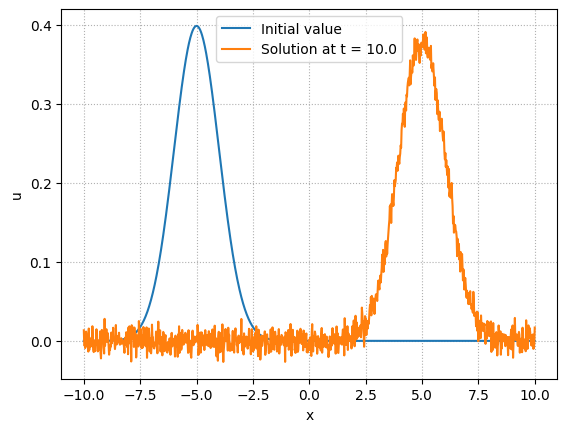

In [1]:
from PINN.AdvectionNet import *
# Testing
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy

# set random seeds
np.random.seed(10)
torch.manual_seed(10);

import numpy as np    
import matplotlib.pyplot as plt

class LinearAdvection1D:
    # Matrix for LA1D 
    A=0
   # Initialization of constants 
    def __init__(self, c, x0, xN, N, deltaT,T):
        self.c = c 
        self.x0 = x0   
        self.xN = xN 
        self.N = N   
        self.deltaT = deltaT   
        self.T = T       
    # CFL number funct.   
    def CFL(self):
        deltaX= (self.xN - self.x0)/self.N
        return np.abs(self.c*self.deltaT/deltaX)
    # check CFL number <=1 or not.
    def checkCFL(self):
        if (self.CFL()<=1):
            flag=True
        else:
            flag=False
        return flag
    # Matrix assembly of LA1D   
    def upwindMatrixAssembly(self):
        alpha_min=min(self.CFL(),0)
        alpha_max=max(self.CFL(),0)
        a1=[alpha_max]*(self.N-1)
        a2=[1+alpha_min-alpha_max]*(self.N)
        a3=[-alpha_min]*(self.N-1)
        self.A=np.diag(a1, -1)+np.diag(a2, 0)+np.diag(a3, 1)

    # Solve u=Au0
    def step(self,u0):
        return np.matmul(self.A,u0) 

#############  
# Start of the code
###################

# constants  
N, x0, xN, deltaT, c, T = 1000, -10.,10., 0.01, 1.0, 10.0
# initialization of constants
LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T) 

# initial value
x = np.linspace(LA1D.x0,LA1D.xN,LA1D.N)
nx = len(x)
u0=(1/(np.sqrt(2*np.pi)))*np.exp(-0.5*((x+5)**2))

#plot of initial value    
plt.plot(x,u0,label="Initial value")
plt.ylabel('u')
plt.xlabel('x')
plt.legend()

# save solutions
nt = int(LA1D.T/LA1D.deltaT)
tgrid = np.linspace(0, T, nt)
u_sol = np.zeros([nt, nx])


# calculating solution if CFL<=1
if LA1D.checkCFL():
    print("CFL number is: ", LA1D.CFL())
    LA1D.upwindMatrixAssembly()
    for i in range(0, nt):
        u_sol[i, :] = u0
        u = LA1D.step(u0)
        u0 = u
else:
    print("CFL number is greater than 1. CFL: ", LA1D.CFL())

u_sol = u_sol + 0.01 * np.random.randn(u_sol.shape[0], u_sol.shape[1])
# ploting the last solution
plt.plot(x,u_sol[-1, :],label="Solution at t = {}".format(LA1D.T))
plt.legend()
plt.grid(linestyle='dotted')

# save data for testing
scipy.io.savemat("../data/LinearOscillator/Pure_Advection.mat", {
    "xgrid": x.reshape(1, -1),
    "tgrid": tgrid.reshape(1, -1),
    "pmc": u_sol
})

# save a smaller dataset
subsample_t = 2
subsample_x = 5
scipy.io.savemat("../data/LinearOscillator/Pure_Advection_small_data.mat", {
    "xgrid": x.reshape(1, -1)[:, 0:-1:subsample_x],
    "tgrid": tgrid.reshape(1, -1)[:, 0:-1:subsample_t],
    "pmc": u_sol[0:-1:subsample_t, 0:-1:subsample_x]
})
print("Training data size = {}\n".format(u_sol[0:-1:subsample_t, 0:-1:subsample_x].shape))

In [2]:
# testing PINN # inverse problem with PINN
#data_path = "../data/LinearOscillator/Pure_Advection.mat"
# subsampled spatial training data
data_path = "../data/LinearOscillator/Pure_Advection_small_data.mat"
# create PINN
pinn = AdvectionNet(indim=2, outdim=1, data_path=data_path, scheduler="ExponentialLR")
# testing training
info = train(
    pinn, pinn.optimizer, pinn.scheduler, batch_size=2**9,
    epochs=200, batch_print=100, mode="all"
)

------------------------------------------------------------

=> Data Loaded at: ../data/LinearOscillator/Pure_Advection_small_data.mat 

----> Total Number of observations = 98802 

------------------------------------------------------------

------------------------------------------------------------------

|                      Epoch 1                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000980
Batch PDE Loss = 0.00016008730400491515 

Batch Data Loss = 0.005283426779770936 

------------------------------------------------------------------

|                      Epoch 2                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000970
Batch PDE Loss = 8.960241231439267e-05 

Batch Data Loss = 0.000275406434764

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000794
Batch PDE Loss = 8.000796036006331e-06 

Batch Data Loss = 0.00011691496746278126 

------------------------------------------------------------------

|                      Epoch 23                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000786
Batch PDE Loss = 7.475290944469801e-06 

Batch Data Loss = 0.00012074004995600644 

------------------------------------------------------------------

|                      Epoch 24                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000778
Batch PDE Loss = 7.35742612102605e-06 

Batch Data Loss = 0.0001161673685655376 

------------------------------------------------------------------

|      

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000636
Batch PDE Loss = 3.2986730519331284e-06 

Batch Data Loss = 0.00011056199646739604 

------------------------------------------------------------------

|                      Epoch 45                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000630
Batch PDE Loss = 3.138350625411414e-06 

Batch Data Loss = 0.00011095190817700844 

------------------------------------------------------------------

|                      Epoch 46                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000624
Batch PDE Loss = 3.0294559228507217e-06 

Batch Data Loss = 0.00011095293016073975 

------------------------------------------------------------------

|  

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000510
Batch PDE Loss = 2.180798664045492e-06 

Batch Data Loss = 0.00010938339115822153 

------------------------------------------------------------------

|                      Epoch 67                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000505
Batch PDE Loss = 2.056173489597307e-06 

Batch Data Loss = 0.00010720998002607561 

------------------------------------------------------------------

|                      Epoch 68                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000500
Batch PDE Loss = 2.022755290399427e-06 

Batch Data Loss = 0.00010649300357067837 

------------------------------------------------------------------

|    

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000409
Batch PDE Loss = 1.3277034315024263e-06 

Batch Data Loss = 0.00010459566890524528 

------------------------------------------------------------------

|                      Epoch 89                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000405
Batch PDE Loss = 1.3821733063834677e-06 

Batch Data Loss = 0.0001060916113539804 

------------------------------------------------------------------

|                      Epoch 90                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000401
Batch PDE Loss = 1.3772544242221903e-06 

Batch Data Loss = 0.00010510110013804095 

------------------------------------------------------------------

|  

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000328
Batch PDE Loss = 1.1018401534814428e-06 

Batch Data Loss = 0.0001036749579477882 

------------------------------------------------------------------

|                      Epoch 111                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000324
Batch PDE Loss = 1.1057477668515164e-06 

Batch Data Loss = 0.00010415211141191457 

------------------------------------------------------------------

|                      Epoch 112                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000321
Batch PDE Loss = 1.2109071842098149e-06 

Batch Data Loss = 0.00010421073769678771 

------------------------------------------------------------------

|

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000263
Batch PDE Loss = 9.5854522712632e-07 

Batch Data Loss = 0.00010351208681143194 

------------------------------------------------------------------

|                      Epoch 133                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000260
Batch PDE Loss = 9.496216411122786e-07 

Batch Data Loss = 0.00010369536893564099 

------------------------------------------------------------------

|                      Epoch 134                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000257
Batch PDE Loss = 9.348612779029656e-07 

Batch Data Loss = 0.00010330969352150136 

------------------------------------------------------------------

|    

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000211
Batch PDE Loss = 8.069201928435791e-07 

Batch Data Loss = 0.0001030364307710438 

------------------------------------------------------------------

|                      Epoch 155                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000208
Batch PDE Loss = 8.502879437086699e-07 

Batch Data Loss = 0.00010368732186987991 

------------------------------------------------------------------

|                      Epoch 156                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000206
Batch PDE Loss = 8.605464713896672e-07 

Batch Data Loss = 0.00010245917778208551 

------------------------------------------------------------------

|   

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000169
Batch PDE Loss = 7.612012106054858e-07 

Batch Data Loss = 0.00010232068633470308 

------------------------------------------------------------------

|                      Epoch 177                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000167
Batch PDE Loss = 7.374112513511363e-07 

Batch Data Loss = 0.00010216962773872552 

------------------------------------------------------------------

|                      Epoch 178                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000165
Batch PDE Loss = 7.203318031672793e-07 

Batch Data Loss = 0.00010171636788796179 

------------------------------------------------------------------

|  

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000135
Batch PDE Loss = 6.676240454947605e-07 

Batch Data Loss = 0.00010185627029910955 

------------------------------------------------------------------

|                      Epoch 199                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000134
Batch PDE Loss = 6.846121876352988e-07 

Batch Data Loss = 0.00010181319920804257 

------------------------------------------------------------------

|                      Epoch 200                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 101 |

---------- 

++ Learning rate reduced, now at = 0.000133
Batch PDE Loss = 6.513540462368913e-07 

Batch Data Loss = 0.00010232229575380025 



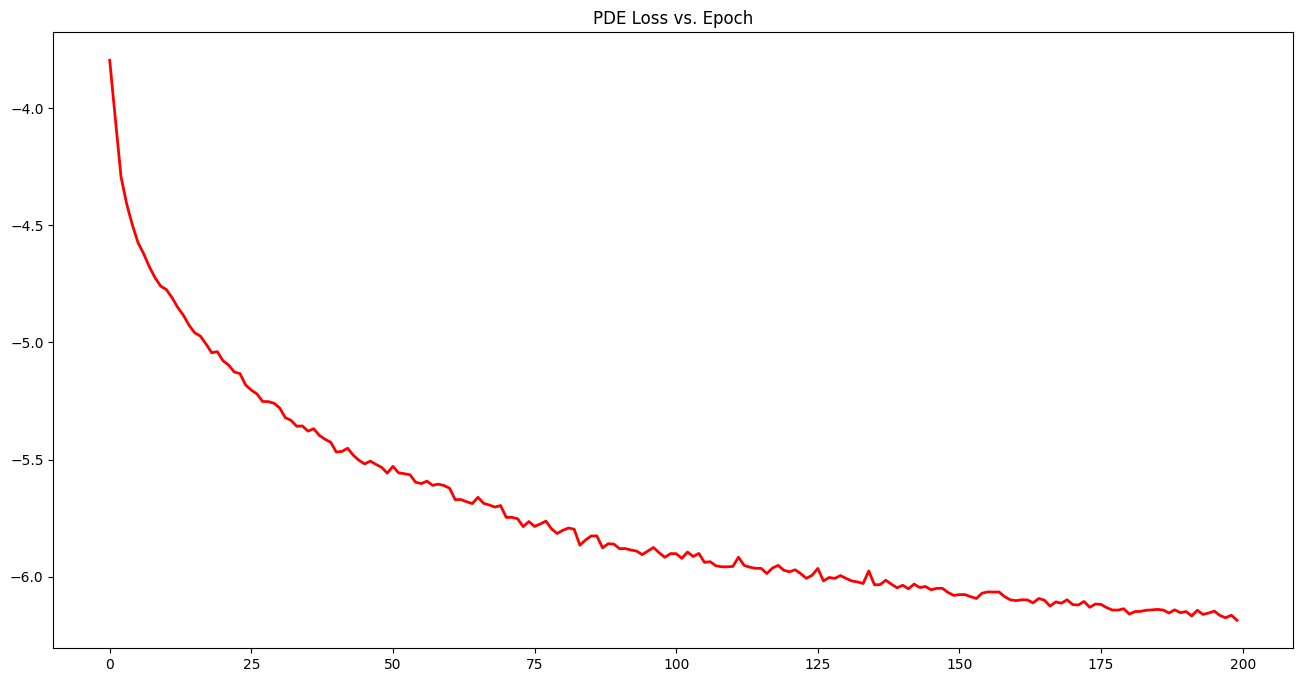

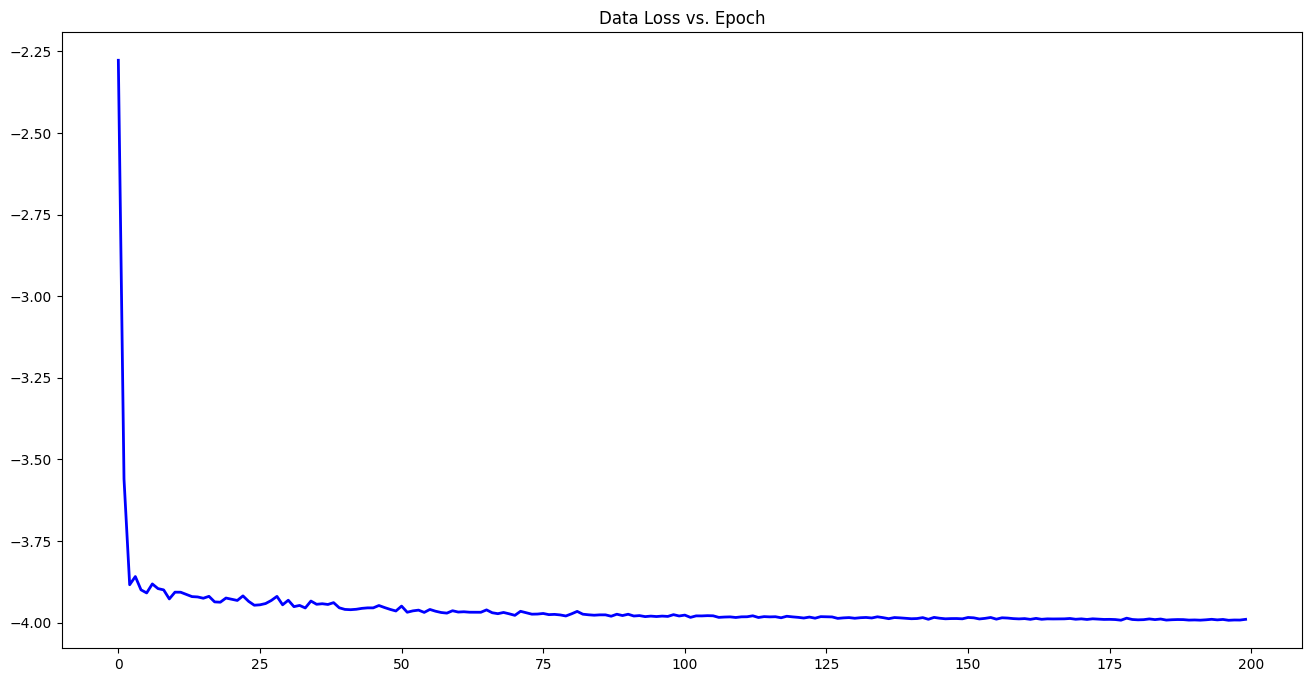

In [3]:
# visualize losses
plt.figure(1, figsize=(16, 8));
plt.plot(np.log10(info["pde_loss"]), lw=2, color="red");
plt.title("PDE Loss vs. Epoch");

plt.figure(2, figsize=(16, 8));
plt.plot(np.log10(info["data_loss"]), lw=2, color="blue");
plt.title("Data Loss vs. Epoch");

# plt.figure(3, figsize=(16, 8));
# plt.plot(np.log10(info["reg_loss"]), lw=2, color="purple");
# plt.title("Regularity Loss vs. Epoch");
query = cartesian_data(pinn.tgrid, pinn.xgrid)

# D_pred = pinn.D_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
# G_pred = pinn.G_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
p_pred = pinn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()

# grids
tgrid = pinn.tgrid.detach().numpy()
xgrid = pinn.xgrid.detach().numpy()

p_exact = pinn.raw_data["pmc"]
dx = pinn.dx.item()
dt = pinn.dt.item()

# plt.figure(1);
# plt.contourf(xgrid, tgrid, G_pred);
# plt.colorbar();

# plt.figure(2);
# plt.plot(xgrid, G_pred[0:-1:10, :].T, alpha=0.4, lw=1.5);
# plt.plot(xgrid, 1.1*np.ones_like(xgrid), "--", lw=4.5, color="red", alpha=0.8, label="exact");
# plt.legend();

In [4]:
nx = 800
xgrid_fine = np.linspace(-10.0, 10.0, nx)
xgrid_fine = torch.tensor(xgrid_fine)
dx = xgrid_fine[1]-xgrid_fine[0]
nt = 1000
tgrid_fine = np.linspace(0., 10.0, nt)
tgrid_fine = torch.tensor(tgrid_fine)
dt = tgrid_fine[1]-tgrid_fine[0]

query_fine = cartesian_data(tgrid_fine, xgrid_fine)

G_pred_fine = pinn.G_nn(query_fine[:, 1][:, None]).reshape(nx, nt).T.detach().numpy()
p_pred_fine = pinn(query_fine).reshape(nx, nt).T.detach().numpy()

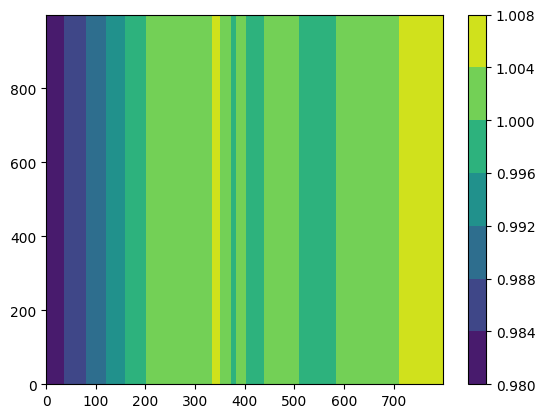

In [5]:
plt.contourf(G_pred_fine); plt.colorbar();

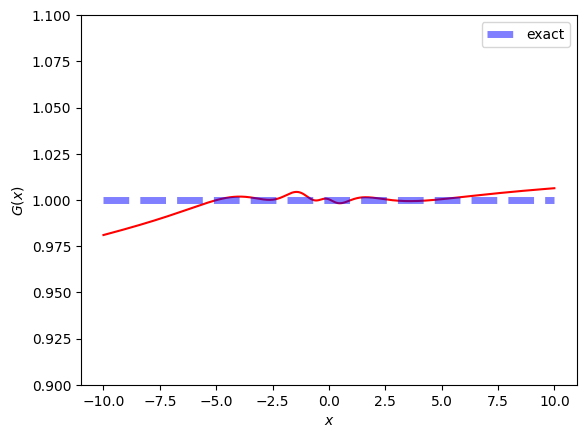

In [29]:
plt.figure(1);
plt.plot(xgrid_fine, G_pred_fine[0, :], color="red");
plt.plot(xgrid_fine, np.ones_like(xgrid_fine), "--", color="blue", lw=5.0, alpha=0.5, label="exact");
plt.ylim([0.9, 1.1]);
plt.legend(); 
plt.xlabel(r"$x$");
plt.ylabel(r"$G(x)$");

(1000, 800)


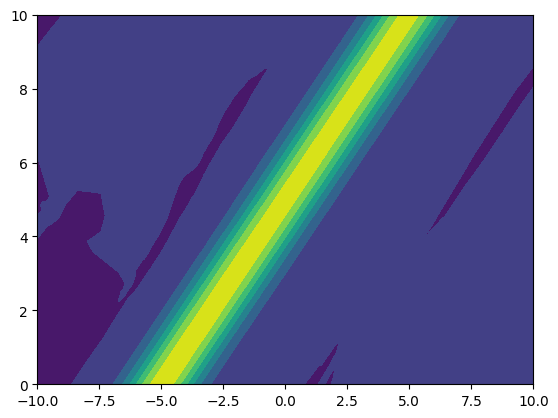

In [30]:
# interpolation
print(p_pred_fine.shape)
plt.contourf(xgrid_fine.detach().numpy(), tgrid_fine.detach().numpy(), p_pred_fine);

(500, 200)


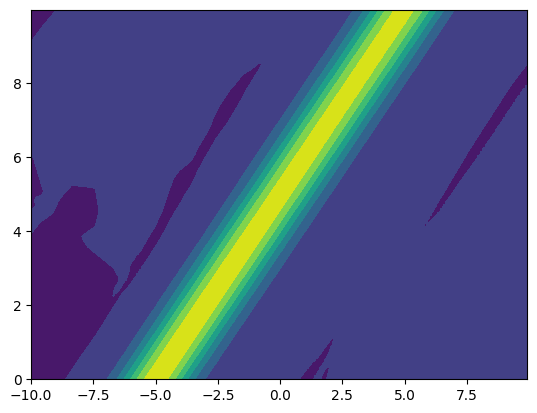

In [31]:
# reconstruction on training dataset
print(p_pred.shape)
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), p_pred);

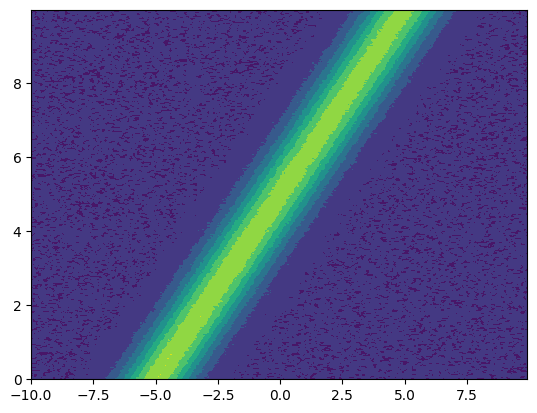

In [32]:
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), pinn.raw_data["pmc"]);

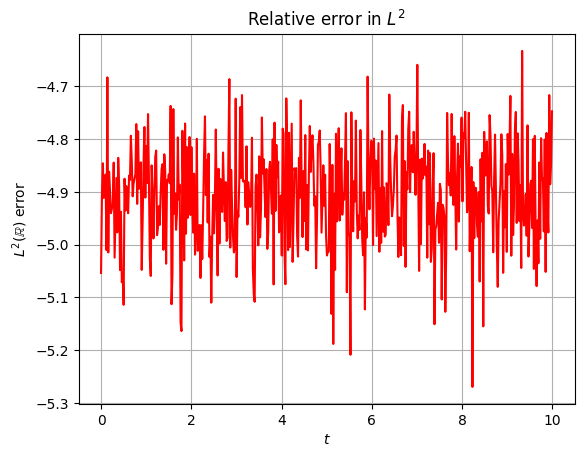

In [59]:
plt.figure(2);
# relative error in L^2 from KDE benchmark
l2_rel_err = np.sum(((p_pred-p_exact)**2)*dx, 1) / np.sum((p_exact**2)*dx, 1)
tgrid = pinn.tgrid.detach().numpy()
plt.plot(tgrid, np.log(l2_rel_err), color="red", lw=1.5);
plt.grid(True);
plt.title(r"Relative error in $L^2$");
plt.xlabel(r"$t$"); 
plt.ylabel(r"$L^2(\mathbb{R})$ error");